Import our standard libraries

In [1]:
import numpy as np
import control as ctrl
import matplotlib.pyplot as plt

Next, define the system matrices for the continuous-time dynamics. Note that we consider both $u$ and $w$ as inputs.

In [2]:
Ac = np.array([[-0.07, 0],[0.07,-0.07]])
Buc = np.array([[0.18],[0]])
Bwc= np.array([[0],[0.07]])
Bc=np.block([Buc, Bwc])
Cc = np.array([[0,1]])
Dc = np.array([[0,0]])
#sysc = ctrl.ss(Ac,Bc_tmp,Cc,Dc)

Sample the system with sampling time $h=5$ seconds, retrieve discrete-time system matrices and separate the B matrix into one part for u and one for w.

In [3]:
h=5
sysd = ctrl.c2d(sysc,h)
A,B_tmp,C,D=ctrl.ssdata(sysd)
B=B_tmp[:,0].reshape(-1,1)
Bw=B_tmp[:,1].reshape(-1,1)

Next, design state feedback using pole placement. Note that the place command does not allow us to put both poles at exactly the same location. The reference and disturbance feed-forward gains are computed using the fomulas in the lecture notes.

In [4]:
L=ctrl.place(A,B,[0.5, 0.5001])
Lr=np.linalg.inv(C@np.linalg.inv(np.eye(2)-A+B@L)@B)
Lw=-np.linalg.inv(C@np.linalg.inv(np.eye(2)-A+B@L)@B)@(C@np.linalg.inv(np.eye(2)-A+B@L)@Bw)

Set up the closed-loop dynamics. For convenient simulation, we define the outputs as the system states and the control signal. First, witout disturbance feed-forward:

$$
x_{t+1}=Ax_t+ Bu_t + B_w w_t, \quad u_t=-Lx_t + L_r r_t \quad \Rightarrow x_{t+1}=(A-BL)x_t + B L_r r_t + B_w w_t
$$

In [18]:
Acl=A-B@L
Bcl=np.block([B@Lr, Bw])
Ccl=np.block([[np.eye(2)],[-L]]);
Dr=np.block([[np.zeros((2,1))],[Lr]])
Dcl=np.block([ [Dr, np.zeros((3,1))]])
sysd_cl=ctrl.ss(Acl,Bcl,Ccl,Dcl,h)

Define input signals: $u$ is a step at time $t=0$, and $w$ is a step at time $t=60$.

In [24]:
stop_time=120
nt=int(stop_time/h)
time=np.linspace(0,stop_time,nt+1)

u=np.ones(nt+1)
d=np.array([0 if t<=60 else 0.1 for t in time])
input_signals=np.block([[u],[d]])

x0 = np.zeros((2,1))
t,y=ctrl.forced_response(sysd_cl, time, input_signals, x0)

Plot the results.

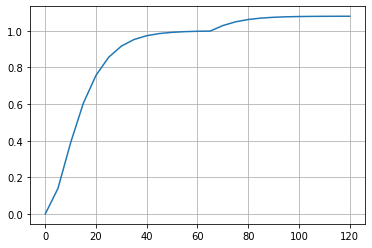

In [25]:

plt.plot(t,y[1,:])
plt.grid()

Notice that we follow the reference without error, but the disturbance is not compensated for.


Redo simulation with disturbance feed-forward added. We first need to update the closed-loop matrices.



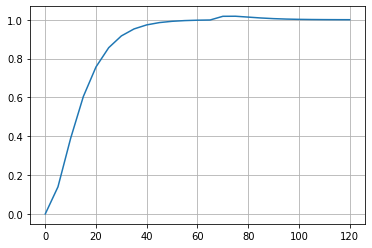

In [26]:
Bcl=np.block([B@Lr, Bw+B@Lw])
Dw=np.block([[np.zeros((2,1))],[Lw]])
Dcl=np.block([ [Dr, Dw]])
sysd_cl2=ctrl.ss(Acl,Bcl,Ccl,Dcl,h)
t,y=ctrl.forced_response(sysd_cl2, time, input_signals, x0)
plt.plot(t,y[1,:])
plt.grid()

The addition of the disturbance feed-forward allows to elimiate the effect of the disturbance in steady-state.